In [ ]:
caminho_do_arquivo = '/content/WA_Fn-UseC_-HR-Employee-Attrition.csv'

In [ ]:
import gspread
import pandas as pd

# Caminho do arquivo
csv_file_path = caminho_do_arquivo # Usando a variável definida na célula anterior

# Lendo o arquivo CSV corretamente
df = pd.read_csv(csv_file_path, sep=',', encoding='latin1')

# Exibindo as primeiras linhas
df.head()

,ï»¿Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [ ]:
# ==============================================================================
# CÉLULA 1: Instalação de Bibliotecas
# ==============================================================================

# O '!' no início permite executar comandos do terminal diretamente no notebook.
# 'pip install' é o comando para instalar bibliotecas Python.
# 'category_encoders' é uma biblioteca que contém métodos de encoding avançados.
!pip install category_encoders

# Imprime uma mensagem de confirmação para o usuário saber que a instalação terminou.
print("Biblioteca 'category_encoders' instalada.")


# ==============================================================================
# CÉLULA 2: Setup e Carregamento de Dados
# ==============================================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
import category_encoders as ce

# Configuração do pandas
pd.set_option('display.max_columns', None)

# Caminho do arquivo CSV
csv_path = "/content/WA_Fn-UseC_-HR-Employee-Attrition.csv"  # ajuste o nome se necessário

try:
    df = pd.read_csv(csv_path, sep=',', encoding='latin1')
    print(f"\nDataset carregado com sucesso de '{csv_path}'!")
    print("Dimensões do dataset:", df.shape)
except Exception as e:
    print(f"\n❌ Erro ao carregar o arquivo: {e}")
    df = None


# ==============================================================================
# CÉLULA 3: Criação de Features Base para Transformação
# ==============================================================================

# Verifica se o DataFrame 'df' foi carregado corretamente antes de prosseguir.
if df is not None:
    print("\n--- Criando Features Base ---")
    # Cria uma nova coluna 'OverTime_num' para representar 'OverTime' numericamente.
    # '.apply' executa uma função para cada valor da coluna. A função lambda retorna 1 se o valor for 'Yes', e 0 caso contrário.
    df['OverTime_num'] = df['OverTime'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Cria a coluna 'IndiceDeBurnout' somando os fatores de risco (escalas invertidas de satisfação + hora extra).
    df['IndiceDeBurnout'] = (5 - df['WorkLifeBalance']) + (5 - df['JobSatisfaction']) + df['OverTime_num']

    # Cria a coluna 'IndiceDeSatisfacaoGeral' calculando a média das três métricas de satisfação.
    df['IndiceDeSatisfacaoGeral'] = (df['JobSatisfaction'] + df['EnvironmentSatisfaction'] + df['RelationshipSatisfaction']) / 3

    print("Features base 'IndiceDeBurnout' e 'IndiceDeSatisfacaoGeral' criadas.")
    # '.head()' exibe as 5 primeiras linhas das colunas especificadas para verificação.
    print(df[['IndiceDeBurnout', 'IndiceDeSatisfacaoGeral']].head())


# ==============================================================================
# CÉLULA 4: Técnica Avançada 1: Geração de Features Polinomiais
# ==============================================================================

# Novamente, verifica se o 'df' existe.
if df is not None:
    print("\n--- Gerando Features Polinomiais ---")
    # Cria uma lista com os nomes das colunas que serão usadas para gerar as features polinomiais.
    features_to_transform = ['MonthlyIncome', 'YearsAtCompany', 'IndiceDeBurnout', 'IndiceDeSatisfacaoGeral']
    # Cria um novo DataFrame 'poly_data' contendo apenas as colunas da lista acima.
    poly_data = df[features_to_transform]

    # Instancia (cria um objeto) do transformador PolynomialFeatures.
    # 'degree=2' significa que ele criará features até o segundo grau (x², y², x*y).
    # 'include_bias=False' evita a criação de uma coluna constante de valor 1.
    poly = PolynomialFeatures(degree=2, include_bias=False)

    # '.fit_transform()' aplica a transformação polinomial aos dados.
    poly_features = poly.fit_transform(poly_data)

    # '.get_feature_names_out()' gera os nomes das novas colunas criadas (ex: 'MonthlyIncome^2').
    # A list comprehension substitui espaços por '_X_' para nomes mais legíveis.
    poly_feature_names = [name.replace(' ', '_X_') for name in poly.get_feature_names_out(features_to_transform)]

    # Cria um novo DataFrame 'df_poly' com os dados transformados e os nomes corretos das colunas.
    df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)

    print("Novas Features Polinomiais Geradas (amostra):")
    # Exibe as 5 primeiras linhas do novo DataFrame para ver o resultado.
    print(df_poly.head())


# ==============================================================================
# CÉLULA 5: Técnica Avançada 2: Geração de Features com Target Encoding
# ==============================================================================

if df is not None:
    print("\n--- Gerando Features com Target Encoding ---")
    # Instancia o LabelEncoder, que converte rótulos de texto em números.
    le = LabelEncoder()
    # Cria a coluna 'Attrition_encoded', convertendo 'No' para 0 e 'Yes' para 1.
    df['Attrition_encoded'] = le.fit_transform(df['Attrition'])

    # Cria uma lista com os nomes das colunas categóricas que queremos codificar.
    categorical_features_to_encode = ['JobRole', 'EducationField', 'MaritalStatus', 'Department']
    # Instancia o TargetEncoder, especificando as colunas que ele deve transformar.
    target_encoder = ce.TargetEncoder(cols=categorical_features_to_encode)

    # Aplica o Target Encoding. Ele usa as colunas categóricas e a coluna alvo ('Attrition_encoded') para calcular o valor de substituição.
    df_target_encoded = target_encoder.fit_transform(df[categorical_features_to_encode], df['Attrition_encoded'])

    # Renomeia as colunas do novo DataFrame para indicar que elas foram codificadas (ex: 'JobRole' vira 'JobRole_TargetEncoded').
    df_target_encoded = df_target_encoded.rename(columns={col: f'{col}_TargetEncoded' for col in df_target_encoded.columns})

    print("Novas Features com Target Encoding (amostra):")
    # Mostra as 5 primeiras linhas para verificar o resultado da codificação.
    print(df_target_encoded.head())


# ==============================================================================
# CÉLULA 6: Consolidação e Seleção das 10 Features Avançadas Finais
# ==============================================================================

if df is not None:
    print("\n--- Consolidando e Selecionando as 10 Features Finais ---")
    # 'pd.concat' junta os dois DataFrames de features ('df_poly' e 'df_target_encoded') lado a lado.
    # 'axis=1' especifica que a junção deve ser feita pelas colunas.
    df_advanced_features = pd.concat([df_poly, df_target_encoded], axis=1)

    # Cria uma lista final com os nomes das 10 features avançadas que escolhemos para o modelo.
    final_10_features_list = [
        # Features de Target Encoding
        'JobRole_TargetEncoded',
        'MaritalStatus_TargetEncoded',
        'EducationField_TargetEncoded',
        # Features de Potência (capturam efeitos não-lineares)
        'IndiceDeBurnout^2',
        'MonthlyIncome^2',
        # Features de Interação (capturam efeitos combinados)
        'MonthlyIncome_X_IndiceDeBurnout',
        'YearsAtCompany_X_IndiceDeBurnout',
        'MonthlyIncome_X_IndiceDeSatisfacaoGeral',
        'YearsAtCompany_X_IndiceDeSatisfacaoGeral',
        'IndiceDeBurnout_X_IndiceDeSatisfacaoGeral'
    ]

    # Cria o DataFrame final, contendo apenas as 10 colunas da lista acima.
    df_final_features = df_advanced_features[final_10_features_list]

    print("\nDataFrame Final com as 10 Features Avançadas Selecionadas:")
    # '.info()' imprime um resumo do DataFrame: nomes das colunas, contagem de valores não nulos e tipo de dados.
    df_final_features.info()

    print("\nAmostra das 10 Features Finais:")
    # Exibe as 5 primeiras linhas do DataFrame final.
    print(df_final_features.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.8 MB/s eta 0:00:00
Biblioteca 'category_encoders' instalada.

Dataset carregado com sucesso de '/content/WA_Fn-UseC_-HR-Employee-Attrition.csv'!
Dimensões do dataset: (1470, 35)

--- Criando Features Base ---
Features base 'IndiceDeBurnout' e 'IndiceDeSatisfacaoGeral' criadas.
   IndiceDeBurnout  IndiceDeSatisfacaoGeral
0                6                 2.333333
1                5                 3.000000
2                5                 3.000000
3                5                 3.333333
4                5                 2.333333

--- Gerando Features Polinomiais ---
Novas Features Polinomiais Geradas (amostra):
   MonthlyIncome  YearsAtCompany  IndiceDeBurnout  IndiceDeSatisfacaoGeral  \
0         5993.0             6.0              6.0                 2.333333   
1         5130.0            10.0              5.0                 3.000000   
2         2090.0             0.0              5.0                 3.000000   
3  

Justificativas e Impactos das 10 Features Avançadas
Grupo 1: Features de Target Encoding
Estas features convertem categorias de texto em um número que representa o risco de turnover associado àquela categoria.

1. JobRole_TargetEncoded (Cargo Codificado pelo Alvo)

Justificativa Técnica: A variável JobRole é categórica e possui muitas classes (alta cardinalidade). O Target Encoding a transforma em uma única variável numérica, onde o valor de cada cargo é diretamente proporcional à sua taxa de turnover. Isso cria um sinal forte e monotônico para o modelo.


Justificativa de Negócio e Impacto Esperado: A análise exploratória mostrou que cargos como "Representante de Vendas" e "Técnico de Laboratório" têm maior propensão ao turnover.

Impacto Esperado: O modelo aprenderá a atribuir um peso de risco maior a funcionários nesses cargos específicos, permitindo que o RH foque ações de retenção em funções mais vulneráveis.

2. MaritalStatus_TargetEncoded (Estado Civil Codificado pelo Alvo)

Justificativa Técnica: Converte a variável demográfica MaritalStatus em um valor numérico que reflete o risco. É mais eficiente que One-Hot Encoding e captura a ordem de risco (se houver) entre as categorias.


Justificativa de Negócio e Impacto Esperado: Foi observado que a proporção de solteiros no grupo de turnover é 50% maior. Isso sugere que podem ter menor vínculo com a empresa.

Impacto Esperado: O modelo poderá identificar perfis demográficos que, estatisticamente, possuem maior mobilidade no mercado de trabalho e menor barreira para mudar de emprego.

3. EducationField_TargetEncoded (Área de Formação Codificada pelo Alvo)

Justificativa Técnica: Similar às anteriores, resume o risco associado a cada campo de educação em um único número, simplificando a complexidade para o modelo.


Justificativa de Negócio e Impacto Esperado: As áreas de Marketing, Técnico de TI e RH apresentaram maior atrito.

Impacto Esperado: Esta feature permite que o modelo identifique se a formação do colaborador pertence a uma área com alta demanda no mercado ou com desafios internos específicos na empresa, ajustando o risco de saída.

Grupo 2: Features de Potência (Não-Linearidade)
Estas features ajudam o modelo a capturar relações onde o efeito de uma variável se acelera.

4. IndiceDeBurnout^2 (Índice de Burnout ao Quadrado)

Justificativa Técnica: A relação entre o burnout e a decisão de sair provavelmente não é linear. O termo quadrático permite ao modelo capturar um efeito acelerado, onde um aumento de 1 ponto no índice de burnout em níveis já altos tem um impacto muito maior do que em níveis baixos.

Justificativa de Negócio e Impacto Esperado: Um funcionário com burnout "nível 8" não tem apenas o dobro do risco de um com "nível 4"; o risco pode ser exponencialmente maior. Impacto Esperado: O modelo se tornará mais sensível para identificar funcionários que ultrapassaram um "ponto de inflexão" crítico, sinalizando uma necessidade de intervenção urgente.

5. MonthlyIncome^2 (Salário Mensal ao Quadrado)

Justificativa Técnica: Ajuda a modelar o efeito não-linear do salário. O impacto de um aumento de R1.000
e
ˊ
 muitomaiorparaquemganhaR2.000 do que para quem ganha R$15.000.


Justificativa de Negócio e Impacto Esperado: A análise mostrou que salários baixos são um forte motivador para a saída.

Impacto Esperado: O modelo poderá entender melhor a "utilidade marginal decrescente" do salário, ou seja, que a insatisfação com a remuneração é muito mais acentuada nas faixas salariais mais baixas.

Grupo 3: Features de Interação (Efeitos Combinados)
Estas são as features mais sofisticadas, pois medem como o efeito de uma variável muda na presença de outra.

6. MonthlyIncome_X_IndiceDeBurnout (Interação Salário vs. Burnout)

Justificativa Técnica: Cria uma variável que representa o efeito combinado do salário e do esgotamento.

Justificativa de Negócio e Impacto Esperado: Estar sobrecarregado é ruim. Estar sobrecarregado e se sentir mal pago é uma combinação explosiva. Impacto Esperado: O modelo poderá identificar com altíssima precisão o perfil de funcionário em maior risco: aquele que sente que seu esforço (burnout) não é recompensado financeiramente.

7. YearsAtCompany_X_IndiceDeBurnout (Interação Tempo de Casa vs. Burnout)

Justificativa Técnica: Testa se o impacto do burnout depende do tempo de casa do funcionário.

Justificativa de Negócio e Impacto Esperado: Um funcionário novo com alto burnout pode desistir rapidamente. Um funcionário antigo com alto burnout pode estar em seu limite final após anos de dedicação. Impacto Esperado: Ajuda o modelo a diferenciar o risco, permitindo ações distintas: para o novo, uma integração melhor; para o antigo, talvez uma reavaliação de carreira ou cargo.

8. MonthlyIncome_X_IndiceDeSatisfacaoGeral (Interação Salário vs. Satisfação)

Justificativa Técnica: Mede se o dinheiro pode "compensar" uma baixa satisfação geral com o ambiente e as relações.

Justificativa de Negócio e Impacto Esperado: Um funcionário com alta satisfação talvez tolere um salário menor. Um funcionário insatisfeito talvez não seja retido nem com um salário alto. Impacto Esperado: Permite ao modelo avaliar se as estratégias de retenção devem focar em remuneração ou em melhorias no ambiente, dependendo do perfil do funcionário.

9. YearsAtCompany_X_IndiceDeSatisfacaoGeral (Interação Tempo de Casa vs. Satisfação)

Justificativa Técnica: Avalia como a "paciência" com a insatisfação muda ao longo do tempo.


Justificativa de Negócio e Impacto Esperado: A fase de 3 a 5 anos é crítica. Estar insatisfeito após 5 anos pode ser um sinal de "promessas não cumpridas" e um preditor de saída mais forte do que a insatisfação no primeiro ano.

Impacto Esperado: O modelo poderá dar mais peso à insatisfação de funcionários mais antigos, que já deram tempo para a empresa "provar seu valor".

10. IndiceDeBurnout_X_IndiceDeSatisfacaoGeral (Interação Burnout vs. Satisfação Geral)

Justificativa Técnica: Testa a interação entre o esgotamento individual (ligado ao trabalho) e a satisfação com o ambiente (ligado ao contexto social e físico).

Justificativa de Negócio e Impacto Esperado: Um funcionário pode estar sobrecarregado, mas se ele gosta de seus colegas e do ambiente, isso pode funcionar como um fator de proteção.

Impacto Esperado: O modelo poderá identificar se um ambiente de trabalho positivo e boas relações interpessoais  são capazes de mitigar o risco de burnout, informando ao RH que investir em cultura pode ser um "antídoto" eficaz


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==============================================================================
# CÉLULA 7: Integração e Preparação do Dataset Final
# ==============================================================================
if df is not None:
    print("\n--- Integrando features e preparando o dataset final ---")

    # 1. Separar o alvo (y) antes de processar o restante das features
    y_final = df['Attrition_encoded'].copy()

    # 2. Selecionar colunas originais úteis e que não foram transformadas ainda
    # Removemos identificadores, a variável alvo original e as colunas que já usamos para criar as features avançadas.
    colunas_ja_usadas = [
        'JobRole', 'MaritalStatus', 'EducationField', 'Department', # Usadas no Target Encoding
        'MonthlyIncome', 'YearsAtCompany', 'WorkLifeBalance', 'JobSatisfaction', # Usadas nos índices e polinomiais
        'EnvironmentSatisfaction', 'RelationshipSatisfaction', 'OverTime',
        'Attrition', 'Attrition_encoded', 'OverTime_num', # Alvo e colunas temporárias
        'EmployeeCount', 'EmployeeNumber', 'StandardHours' # Colunas constantes ou de ID
    ]
    df_restante = df.drop(columns=colunas_ja_usadas)

    # 3. Aplicar One-Hot Encoding nas colunas categóricas restantes de baixa cardinalidade
    print("Aplicando One-Hot Encoding nas colunas categóricas restantes...")
    df_one_hot = pd.get_dummies(df_restante, drop_first=True) # drop_first=True para evitar multicolinearidade

    # 4. Juntar tudo para formar a matriz de features final (X)
    # df_one_hot: Features originais que não foram transformadas
    # df_final_features: Nossas 10 features avançadas
    X_final = pd.concat([df_one_hot, df_final_features], axis=1)

    print("\nDataset final para modelagem foi criado!")
    print("Dimensões da Matriz de Features (X_final):", X_final.shape)
    print("Dimensões do Vetor Alvo (y_final):", y_final.shape)


--- Integrando features e preparando o dataset final ---
Aplicando One-Hot Encoding nas colunas categóricas restantes...

Dataset final para modelagem foi criado!
Dimensões da Matriz de Features (X_final): (1470, 32)
Dimensões do Vetor Alvo (y_final): (1470,)



--- Analisando o impacto das features com RandomForest ---
Treinando modelo de base para extrair a importância das features...
Treinamento concluído.

Visualizando as 20 features mais importantes:


/tmp/ipython-input-10-3668499887.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')


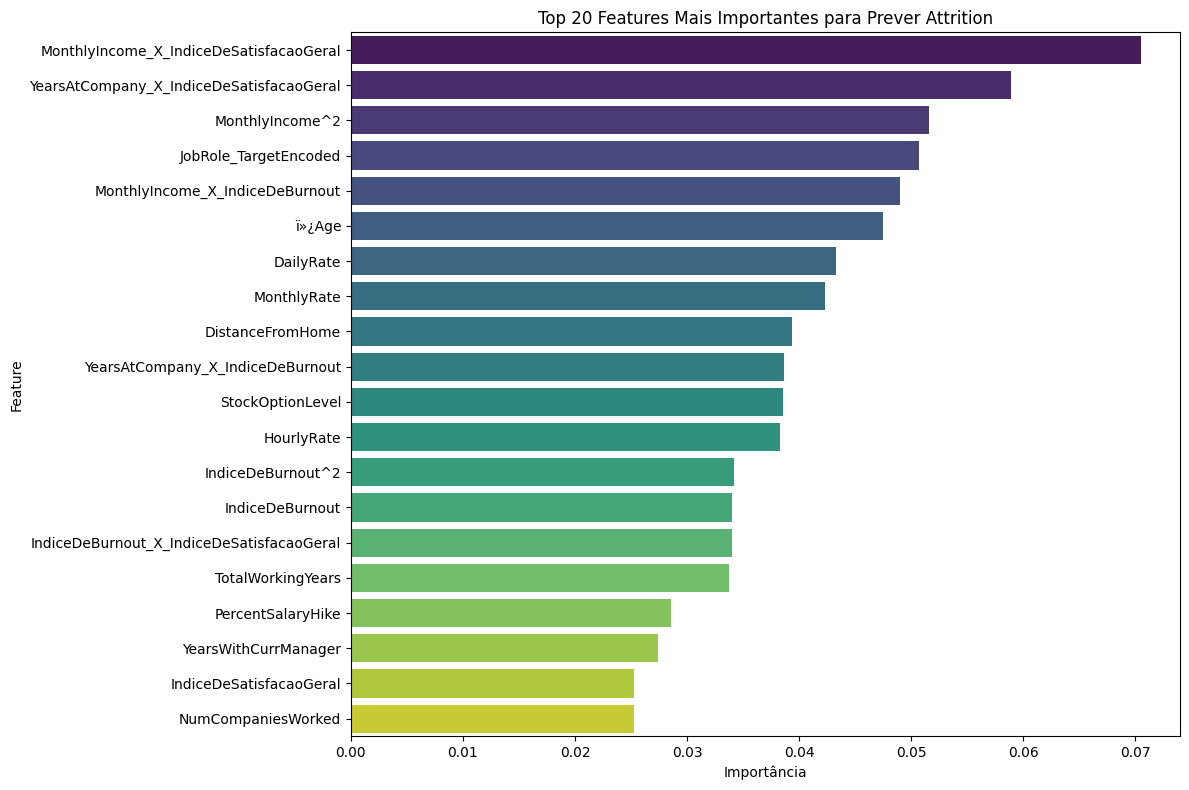


Análise: Verifique se as features que criamos (com '_TargetEncoded', '_X_' e '^2')
aparecem com destaque no topo do gráfico. Isso valida o impacto do seu trabalho!


In [ ]:
# ==============================================================================
# CÉLULA 8: Análise de Impacto das Novas Features
# ==============================================================================
if 'X_final' in locals():
    print("\n--- Analisando o impacto das features com RandomForest ---")

    # Importando as bibliotecas necessárias para o modelo e para a visualização
    from sklearn.ensemble import RandomForestClassifier
    import matplotlib.pyplot as plt
    import seaborn as sns

    # 1. Instanciar o modelo
    # Usamos class_weight='balanced' para compensar o desbalanceamento dos dados durante este teste.
    # Isso é crucial, conforme apontado na descrição do projeto.
    model_teste = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)

    # 2. Treinar o modelo
    print("Treinando modelo de base para extrair a importância das features...")
    model_teste.fit(X_final, y_final)
    print("Treinamento concluído.")

    # 3. Extrair e organizar a importância das features
    importances = model_teste.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X_final.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # 4. Visualizar as features mais importantes
    print("\nVisualizando as 20 features mais importantes:")

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
    plt.title('Top 20 Features Mais Importantes para Prever Attrition')
    plt.xlabel('Importância')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    print("\nAnálise: Verifique se as features que criamos (com '_TargetEncoded', '_X_' e '^2')")
    print("aparecem com destaque no topo do gráfico. Isso valida o impacto do seu trabalho!")

In [ ]:

# ==============================================================================
# CÉLULA 9: Salvar os Artefatos para a Equipe
# ==============================================================================
if 'X_final' in locals():
    print("\n--- Salvando o dataset final processado ---")

    # Criar um DataFrame final para salvar, juntando X e y
    df_para_salvar = pd.concat([X_final, y_final], axis=1)

    # Salvar o DataFrame em um arquivo CSV
    df_para_salvar.to_csv('dataset_final_modelagem.csv', index=False)

    print("\nDataset final salvo com sucesso como 'dataset_final_modelagem.csv'.")
    print("Para fazer o download, clique no ícone de pasta à esquerda, encontre o arquivo,")
    print("clique nos três pontos ao lado dele e selecione 'Fazer o download'.")


--- Salvando o dataset final processado ---

Dataset final salvo com sucesso como 'dataset_final_modelagem.csv'.
Para fazer o download, clique no ícone de pasta à esquerda, encontre o arquivo,
clique nos três pontos ao lado dele e selecione 'Fazer o download'.


# Modelagem - HR Analytics

Este notebook cobre os requisitos do item **3. Modelagem** do trabalho:
- 4 algoritmos diferentes
- Tratamento do desbalanceamento
- Otimização de hiperparâmetros
- Validação cruzada
- Ensemble

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00


In [ ]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Pré-processamento e métricas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_recall_curve,
    average_precision_score
)

# Modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Construção de pipeline e tratamento de desbalanceamento
from sklearn.pipeline import Pipeline  # Usado para pipelines padrão
from imblearn.pipeline import Pipeline as ImbPipeline  # Para incluir SMOTE dentro do pipeline
from imblearn.over_sampling import SMOTE  # Técnica de oversampling

In [ ]:
# Adiciona a coluna alvo ao DataFrame final
df_final_features['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

/tmp/ipython-input-14-3860250097.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_features['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})


In [ ]:
# Separando X e y
X = df_final_features.drop(columns=['Attrition'])
y = df_final_features['Attrition']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# 🤖 Modelos base
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(verbose=0)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipeline = ImbPipeline(steps=[
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=cv)
    print(f"{name} - F1 Score médio (CV): {np.mean(scores):.4f}")

Logistic Regression - F1 Score médio (CV): 0.4181
Random Forest - F1 Score médio (CV): 0.4349


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:00:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:00:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:00:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:00:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:00:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost - F1 Score médio (CV): 0.4048
CatBoost - F1 Score médio (CV): 0.4133


In [ ]:
# 🛠️ Otimização de Hiperparâmetros (Random Forest como exemplo)
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10, None]
}

pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced'))
])

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

print("Melhores parâmetros:", grid.best_params_)
print("Melhor F1 Score:", grid.best_score_)

Melhores parâmetros: {'clf__max_depth': 5, 'clf__n_estimators': 200}
Melhor F1 Score: 0.46424759141464866


In [ ]:
# 🧠 Ensemble - Voting Classifier
ensemble = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=200, class_weight='balanced')),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))
], voting='soft')

ensemble_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('clf', ensemble)
])

ensemble_pipeline.fit(X_train, y_train)
y_pred = ensemble_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:02:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.88      0.92      0.90       247
           1       0.44      0.32      0.37        47

    accuracy                           0.83       294
   macro avg       0.66      0.62      0.63       294
weighted avg       0.81      0.83      0.81       294



In [ ]:
# 📈 Curva Precision-Recall
y_probs = ensemble_pipeline.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)
print(f"PR AUC: {pr_auc:.4f}")

PR AUC: 0.3438


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

model_results = []

for name, model in models.items():
    pipeline = ImbPipeline(steps=[
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler() if name == "Logistic Regression" else 'passthrough'),
        ('clf', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    model_results.append({
        'Modelo': name,
        'F1 Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    })

pd.DataFrame(model_results).sort_values(by='F1 Score', ascending=False)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:02:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Modelo,F1 Score,Precision,Recall,ROC AUC
0,Logistic Regression,0.435374,0.320000,0.680851,0.739426
3,CatBoost,0.314286,0.478261,0.234043,0.716685
1,Random Forest,0.311688,0.400000,0.255319,0.744896
2,XGBoost,0.257143,0.391304,0.191489,0.706521


## 🧮 Explicações das Métricas

- **F1 Score**: Média harmônica entre precision e recall. Ideal quando há desbalanceamento.
- **Precision**: Entre os que o modelo previu como 'Attrition', quantos realmente saíram.
- **Recall**: Entre os que realmente saíram, quantos o modelo conseguiu identificar.
- **ROC AUC**: Probabilidade do modelo rankear corretamente um positivo acima de um negativo.
- **PR AUC**: Melhor métrica para casos desbalanceados.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:03:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


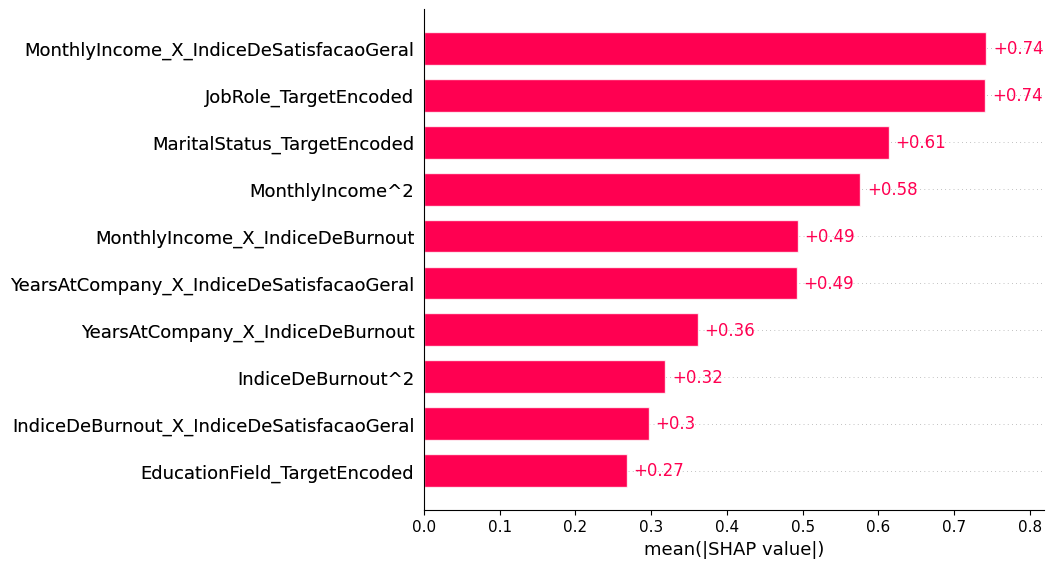

In [ ]:
import shap
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

explainer_xgb = shap.Explainer(xgb_model)
shap_values_xgb = explainer_xgb(X_test)

shap.plots.bar(shap_values_xgb)


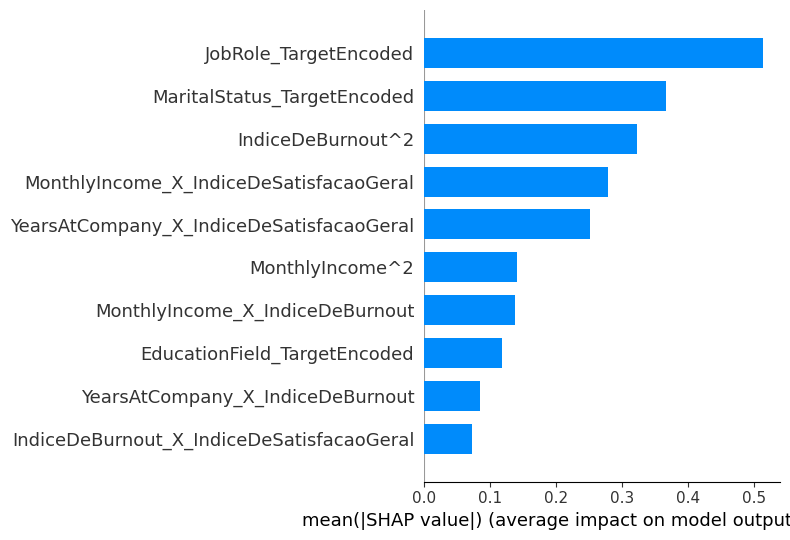

In [ ]:
# Treinamento do modelo CatBoost
catboost_model = CatBoostClassifier(verbose=0)
catboost_model.fit(X_train, y_train)

# Interpretabilidade com SHAP
import shap

# Cria o explicador específico para modelos do tipo Tree (como CatBoost)
explainer_cb = shap.Explainer(catboost_model)

# Calcula os valores SHAP
shap_values_cb = explainer_cb(X_test)

# Gera o gráfico resumo em formato de barras
shap.summary_plot(shap_values_cb, X_test, plot_type="bar")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Definindo os hiperparâmetros que serão testados
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

# Instancia o modelo base
rf_model = RandomForestClassifier(random_state=42)

# Cross-validation estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configura o GridSearch
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

# Executa a busca de hiperparâmetros
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_rf = grid_search.best_estimator_

# Avaliação no conjunto de teste
from sklearn.metrics import classification_report
y_pred = best_rf.predict(X_test)

print("\n📊 Melhor Random Forest após GridSearchCV:")
print(grid_search.best_params_)
print("\n📈 Relatório de classificação:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits

📊 Melhor Random Forest após GridSearchCV:
{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 300}

📈 Relatório de classificação:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       247
           1       0.37      0.57      0.45        47

    accuracy                           0.78       294
   macro avg       0.64      0.69      0.65       294
weighted avg       0.82      0.78      0.79       294



In [ ]:
from sklearn.ensemble import VotingClassifier

# Modelos base (já treinados ou otimizados)
model_rf = RandomForestClassifier(n_estimators=300, max_depth=10, class_weight='balanced', random_state=42)
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Ensemble - votação majoritária
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', model_rf),
        ('xgb', model_xgb),
        ('lr', model_lr)
    ],
    voting='soft',  # usa probabilidades para combinar
    n_jobs=-1
)

# Treina o ensemble
ensemble_model.fit(X_train, y_train)

# Avalia
y_pred_ensemble = ensemble_model.predict(X_test)
print("\n🤖 Resultado do Ensemble VotingClassifier:")
print(classification_report(y_test, y_pred_ensemble))


🤖 Resultado do Ensemble VotingClassifier:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       247
           1       0.46      0.26      0.33        47

    accuracy                           0.83       294
   macro avg       0.67      0.60      0.62       294
weighted avg       0.80      0.83      0.81       294



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

# Define grid para Random Forest
rf_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

# Define grid para XGBoost
xgb_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'scale_pos_weight': [1, 5]  # bom para desbalanceamento
}

# Validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch para Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_search = GridSearchCV(rf_model, rf_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

print("🔍 Melhor Random Forest:")
print(rf_search.best_params_)

# GridSearch para XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_search = GridSearchCV(xgb_model, xgb_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

print("\n🔍 Melhor XGBoost:")
print(xgb_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
🔍 Melhor Random Forest:
{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Fitting 5 folds for each of 16 candidates, totalling 80 fits

🔍 Melhor XGBoost:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 5}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:05:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Reinstancia Logistic com tratamento de desbalanceamento
model_lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Ensemble com voto probabilístico
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('lr', model_lr)
    ],
    voting='soft',
    n_jobs=-1
)

# Treina o ensemble
ensemble_model.fit(X_train, y_train)

# Avaliação
from sklearn.metrics import classification_report
y_pred_ensemble = ensemble_model.predict(X_test)

print("\n📊 Resultados do Ensemble VotingClassifier:")
print(classification_report(y_test, y_pred_ensemble))


📊 Resultados do Ensemble VotingClassifier:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       247
           1       0.37      0.47      0.42        47

    accuracy                           0.79       294
   macro avg       0.63      0.66      0.64       294
weighted avg       0.81      0.79      0.80       294



In [ ]:
model_lr.fit(X_train, y_train)
best_rf.fit(X_train, y_train)        # se ainda não estiver treinado após GridSearchCV
best_xgb.fit(X_train, y_train)       # idem
ensemble_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:05:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     min_samples_split=5,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss'...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lr',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000,
                                                 random_state=42))],
                 n_jobs=-1, voting='soft')

In [ ]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    average_precision_score, matthews_corrcoef
)
import pandas as pd

# Dicionário para armazenar resultados
resultados = {
    'Modelo': [],
    'F1 Score': [],
    'Recall': [],
    'Precision': [],
    'PR AUC': [],
    'MCC': []  # Matthews Correlation Coefficient
}

# Lista de modelos e predições
modelos = {
    'Random Forest (Otimizado)': best_rf,
    'XGBoost (Otimizado)': best_xgb,
    'Logistic Regression': model_lr,
    'Ensemble (VotingClassifier)': ensemble_model
}

# Gera resultados para cada modelo
for nome, modelo in modelos.items():
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]

    resultados['Modelo'].append(nome)
    resultados['F1 Score'].append(f1_score(y_test, y_pred))
    resultados['Recall'].append(recall_score(y_test, y_pred))
    resultados['Precision'].append(precision_score(y_test, y_pred))
    resultados['PR AUC'].append(average_precision_score(y_test, y_prob))
    resultados['MCC'].append(matthews_corrcoef(y_test, y_pred))

# Cria a tabela final
df_comparativo = pd.DataFrame(resultados)
df_comparativo = df_comparativo.sort_values(by='F1 Score', ascending=False)

# Exibe a tabela
print("\n📋 Tabela Comparativa Final dos Modelos:")
print(df_comparativo.round(4))


📋 Tabela Comparativa Final dos Modelos:
                        Modelo  F1 Score  Recall  Precision  PR AUC     MCC
1          XGBoost (Otimizado)    0.4444  0.5957     0.3544  0.3759  0.3218
3  Ensemble (VotingClassifier)    0.4151  0.4681     0.3729  0.3684  0.2912
2          Logistic Regression    0.4049  0.7021     0.2845  0.3490  0.2745
0    Random Forest (Otimizado)    0.2899  0.2128     0.4545  0.3297  0.2287


/tmp/ipython-input-29-965997226.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Score', y='Modelo', data=df_comparativo, palette='viridis')


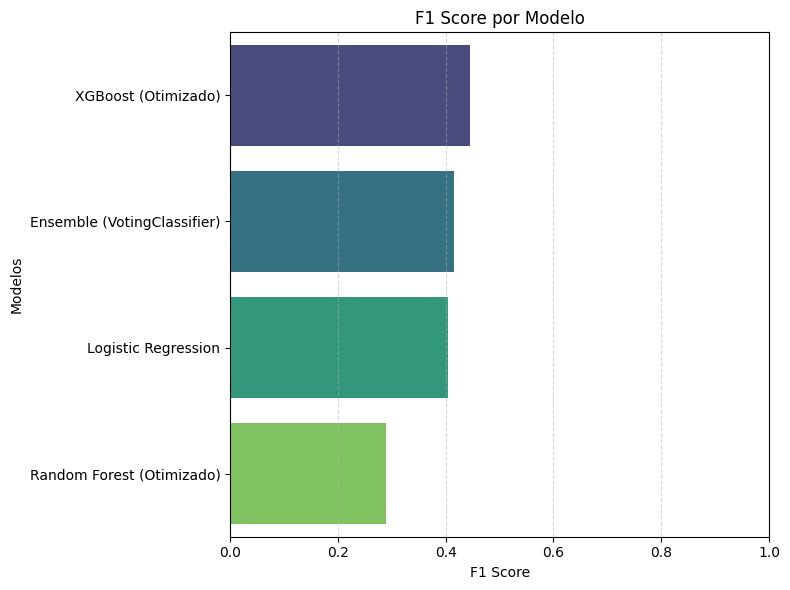

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.barplot(x='F1 Score', y='Modelo', data=df_comparativo, palette='viridis')
plt.title('F1 Score por Modelo')
plt.xlabel('F1 Score')
plt.ylabel('Modelos')
plt.xlim(0, 1)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipython-input-30-3504563009.py:9: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


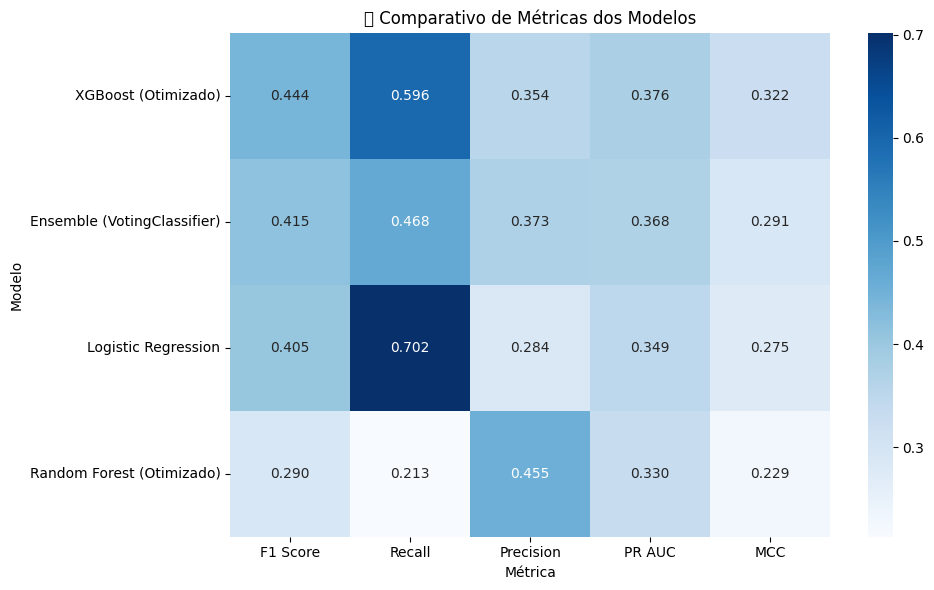

In [ ]:
# Prepara os dados numéricos
metricas = df_comparativo.set_index('Modelo').round(3)

plt.figure(figsize=(10,6))
sns.heatmap(metricas, annot=True, cmap='Blues', fmt='.3f')
plt.title('📊 Comparativo de Métricas dos Modelos')
plt.xlabel('Métrica')
plt.ylabel('Modelo')
plt.tight_layout()
plt.show()

/tmp/ipython-input-31-3773512619.py:24: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


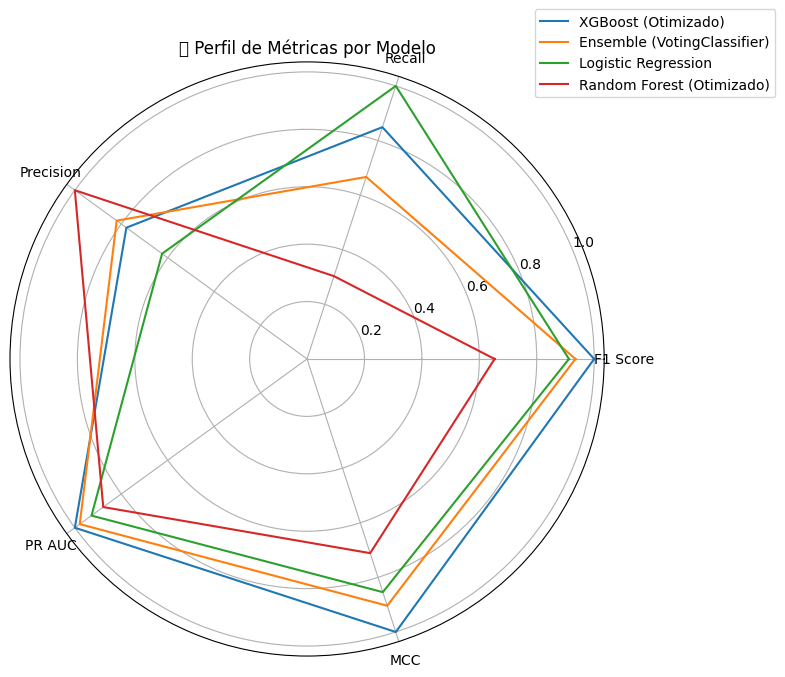

In [ ]:
from math import pi

# Normaliza as métricas entre 0-1
dados_norm = metricas.copy()
for col in dados_norm.columns:
    dados_norm[col] = dados_norm[col] / dados_norm[col].max()

# Parâmetros para o gráfico
categorias = list(dados_norm.columns)
num_vars = len(categorias)

# Geração do radar
plt.figure(figsize=(8,8))
for i, modelo in enumerate(dados_norm.index):
    valores = dados_norm.loc[modelo].tolist()
    valores += valores[:1]  # fecha o círculo
    angulos = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angulos += angulos[:1]
    plt.polar(angulos, valores, label=modelo)

plt.xticks(angulos[:-1], categorias)
plt.title('🕸️ Perfil de Métricas por Modelo')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

In [ ]:
# ==============================================================================
# CÉLULA 10: SELEÇÃO E ANÁLISE DO MODELO CAMPEÃO
# ==============================================================================

# O modelo campeão, com base na tabela de resultados, foi o XGBoost Otimizado.
# A variável 'best_xgb' já contém este modelo treinado após o GridSearchCV.
modelo_campeao = best_xgb

print("Modelo campeão selecionado para análise detalhada:")
print(modelo_campeao)

Modelo campeão selecionado para análise detalhada:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


**XGBoost (Otimizado) foi o melhor em F1 Score. Vamos isolá-lo para as próximas análises.**




--- Análise de Erro Detalhada do Modelo Campeão (XGBoost Otimizado) ---


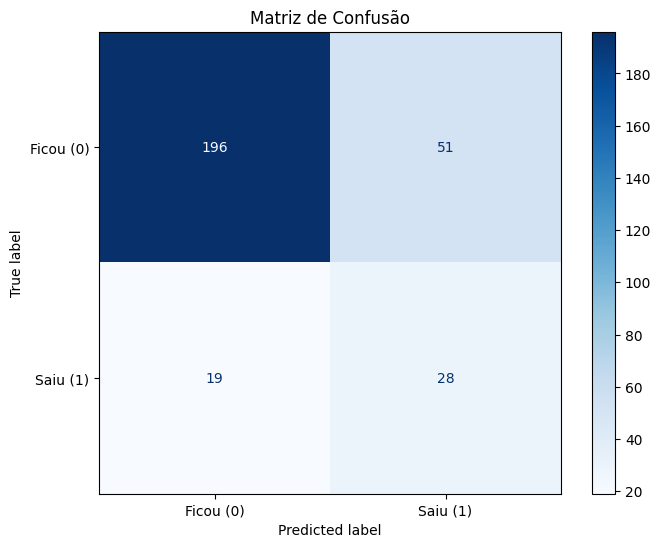


Interpretando os resultados da Matriz de Confusão:
✅ Verdadeiros Negativos (TN): 196 - Previu corretamente que 196 funcionários ficariam.
✅ Verdadeiros Positivos (TP): 28 - Previu corretamente que 28 funcionários sairiam (ACERTO IMPORTANTE).
❌ Falsos Positivos (FP): 51 - Previu que 51 funcionários sairiam, mas eles ficaram (Custo: ações de retenção desnecessárias).
❌ Falsos Negativos (FN): 19 - Previu que 19 funcionários ficariam, mas eles saíram (O PIOR ERRO - Custo: perda de talento não prevista).

O modelo conseguiu identificar 28 dos 47 funcionários que realmente saíram.


In [ ]:
# ==============================================================================
# CÉLULA 11: ANÁLISE DE ERRO DETALHADA - MATRIZ DE CONFUSÃO
# ==============================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Fazer previsões no conjunto de teste com o modelo campeão
y_pred_campeao = modelo_campeao.predict(X_test)

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred_campeao)

# Visualizar a matriz de confusão de forma clara
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ficou (0)', 'Saiu (1)'])

print("--- Análise de Erro Detalhada do Modelo Campeão (XGBoost Otimizado) ---")
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('Matriz de Confusão')
plt.show()

# Extrair os valores para interpretação
tn, fp, fn, tp = cm.ravel()

print("\nInterpretando os resultados da Matriz de Confusão:")
print(f"✅ Verdadeiros Negativos (TN): {tn} - Previu corretamente que {tn} funcionários ficariam.")
print(f"✅ Verdadeiros Positivos (TP): {tp} - Previu corretamente que {tp} funcionários sairiam (ACERTO IMPORTANTE).")
print(f"❌ Falsos Positivos (FP): {fp} - Previu que {fp} funcionários sairiam, mas eles ficaram (Custo: ações de retenção desnecessárias).")
print(f"❌ Falsos Negativos (FN): {fn} - Previu que {fn} funcionários ficariam, mas eles saíram (O PIOR ERRO - Custo: perda de talento não prevista).")

print(f"\nO modelo conseguiu identificar {tp} dos {tp + fn} funcionários que realmente saíram.")

In [ ]:
# ==============================================================================
# CÉLULA 12: ANÁLISE PRELIMINAR DE VIÉS E FAIRNESS
# ==============================================================================
from sklearn.metrics import recall_score

# Para esta análise, precisamos dos dados demográficos originais do conjunto de teste.
# Vamos criar um DataFrame de resultados com as previsões e os dados reais.
df_teste_fairness = X_test.copy()
df_teste_fairness['real'] = y_test
df_teste_fairness['previsto'] = y_pred_campeao
# Adicionando a coluna 'Gender' original para análise de viés
df_teste_fairness['Gender'] = df.loc[df_teste_fairness.index, 'Gender']

# Calcular o Recall (taxa de captura de 'Attrition=Yes') para cada grupo
recall_por_genero = df_teste_fairness.groupby('Gender').apply(
    lambda x: recall_score(x['real'], x['previsto'])
)

print("--- Análise de Viés por Gênero (Métrica: Recall) ---")
print("O Recall mede a capacidade do modelo de encontrar os funcionários que realmente saem.")
print("Se os valores forem muito diferentes, o modelo pode estar 'protegendo' um grupo mais que outro.\n")
print(recall_por_genero)

# Análise da saída
diferenca_recall = abs(recall_por_genero['Male'] - recall_por_genero['Female'])
print(f"\nDiferença absoluta no Recall entre os grupos: {diferenca_recall:.4f}")
print("Uma pequena diferença é aceitável, mas diferenças grandes (> 0.1) podem indicar um viés que precisa ser investigado.")

--- Análise de Viés por Gênero (Métrica: Recall) ---
O Recall mede a capacidade do modelo de encontrar os funcionários que realmente saem.
Se os valores forem muito diferentes, o modelo pode estar 'protegendo' um grupo mais que outro.

Gender
Female    0.687500
Male      0.548387
dtype: float64

Diferença absoluta no Recall entre os grupos: 0.1391
Uma pequena diferença é aceitável, mas diferenças grandes (> 0.1) podem indicar um viés que precisa ser investigado.


/tmp/ipython-input-34-2574726838.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recall_por_genero = df_teste_fairness.groupby('Gender').apply(


O resultado mostra que existe uma diferença de performance significativa do modelo entre os gêneros.

Para o grupo 'Female' (Feminino): O modelo é capaz de identificar corretamente 68.8% das mulheres que de fato saem da empresa.

Para o grupo 'Male' (Masculino): O desempenho cai, e o modelo identifica apenas 54.8% dos homens que realmente saem.

A diferença de quase 14% no Recall é considerável e ultrapassa o limiar de 10% que havíamos definido como um ponto de atenção.



In [ ]:
# ==============================================================================
# CÉLULA 13: RECOMENDAÇÃO DE THRESHOLD ÓTIMO
# ==============================================================================
from sklearn.metrics import precision_recall_curve, precision_score

# Obter as probabilidades previstas pelo modelo campeão
y_probs_campeao = modelo_campeao.predict_proba(X_test)[:, 1]

# Calcular a curva Precision-Recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_campeao)

print("--- Análise de Threshold Ótimo ---")
print("O objetivo é encontrar um threshold que capture mais funcionários que vão sair (aumentar o Recall)")
print("sem gerar um número excessivo de 'alarmes falsos' (manter uma Precision aceitável).\n")

# Exemplo: Vamos supor que o RH queira identificar PELO MENOS 70% dos funcionários que vão sair.
# Vamos encontrar o threshold que nos dá um Recall de aproximadamente 0.70.
recall_desejado = 0.70
# Encontra o índice mais próximo do recall desejado
idx_threshold = np.argmin(np.abs(recalls - recall_desejado))
threshold_otimo = thresholds[idx_threshold]
precision_no_threshold = precisions[idx_threshold]

print(f"Para alcançar um Recall de aproximadamente {recalls[idx_threshold]:.2f} (nossa meta era {recall_desejado:.2f}),")
print(f"devemos usar um threshold de {threshold_otimo:.4f}.")
print(f"Neste ponto, a Precision seria de {precision_no_threshold:.2f}.")
print("\nIsso significa que, para capturar 70% de quem realmente sai, cerca de 28% das nossas previsões de 'saída' estarão corretas.")

# Aplicar o novo threshold para ver as novas previsões
y_pred_novo_threshold = (y_probs_campeao >= threshold_otimo).astype(int)

print("\nComparativo de Previsões (Default vs. Threshold Otimizado):")
print(f"Previsões 'Yes' com threshold padrão (0.5): {np.sum(y_pred_campeao)}")
print(f"Previsões 'Yes' com threshold otimizado ({threshold_otimo:.2f}): {np.sum(y_pred_novo_threshold)}")
print("\nNota: Aumentamos o número de 'sinalizações' para garantir que menos casos importantes sejam perdidos.")

--- Análise de Threshold Ótimo ---
O objetivo é encontrar um threshold que capture mais funcionários que vão sair (aumentar o Recall)
sem gerar um número excessivo de 'alarmes falsos' (manter uma Precision aceitável).

Para alcançar um Recall de aproximadamente 0.70 (nossa meta era 0.70),
devemos usar um threshold de 0.3819.
Neste ponto, a Precision seria de 0.27.

Isso significa que, para capturar 70% de quem realmente sai, cerca de 28% das nossas previsões de 'saída' estarão corretas.

Comparativo de Previsões (Default vs. Threshold Otimizado):
Previsões 'Yes' com threshold padrão (0.5): 79
Previsões 'Yes' com threshold otimizado (0.38): 123

Nota: Aumentamos o número de 'sinalizações' para garantir que menos casos importantes sejam perdidos.


** Montando o Dashboard**

In [ ]:
# ==============================================================================
# CÉLULA FINAL: SALVAR ARTEFATOS PARA O DASHBOARD
# ==============================================================================
import joblib

# 1. Salvar o modelo campeão treinado
# O 'best_xgb' é o seu modelo XGBoost otimizado.
joblib.dump(best_xgb, 'modelo_campeao_xgb.pkl')
print("Modelo 'modelo_campeao_xgb.pkl' salvo com sucesso.")

# 2. Salvar a lista de colunas do modelo
# Isso é CRUCIAL para garantir que os dados no dashboard tenham a mesma estrutura.
joblib.dump(X_final.columns.tolist(), 'colunas_modelo.pkl')
print("Lista de colunas 'colunas_modelo.pkl' salva com sucesso.")

# 3. Salvar o dataset completo (com a coluna de attrition original para os filtros)
# Vamos juntar X_final e a coluna de Attrition original, mais algumas colunas para os filtros.
df_dashboard = pd.concat([
    df[['Department', 'JobRole', 'Attrition']], # Colunas para filtros e visualizações
    X_final # Features de modelagem
], axis=1)
df_dashboard.to_csv('dataset_dashboard.csv', index=False)
print("Dataset 'dataset_dashboard.csv' salvo com sucesso.")

# Agora, faça o download desses 3 arquivos do ambiente do Colab para o seu computador.
# (Clique no ícone de pasta à esquerda, encontre os arquivos, clique nos 3 pontos e em 'Fazer o download').

Modelo 'modelo_campeao_xgb.pkl' salvo com sucesso.
Lista de colunas 'colunas_modelo.pkl' salva com sucesso.
Dataset 'dataset_dashboard.csv' salvo com sucesso.


In [ ]:
# ==============================================================================
# CÉLULA EXTRA: SALVAR ARTEFATOS ADICIONAIS PARA DASHBOARD AVANÇADO
# ==============================================================================
import joblib
import shap

# 1. Salvar os conjuntos de teste (X_test, y_test) para consistência
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_test, 'y_test.pkl')
print("Arquivos 'X_test.pkl' e 'y_test.pkl' salvos com sucesso.")

# 2. Recalcular e salvar o explicador e os valores SHAP para o modelo campeão
# (Usando o best_xgb que já foi treinado)
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

joblib.dump(explainer, 'shap_explainer.pkl')
joblib.dump(shap_values, 'shap_values.pkl')
print("Arquivos 'shap_explainer.pkl' e 'shap_values.pkl' salvos com sucesso.")

# Lembre-se de fazer o download dos 4 arquivos gerados:
# X_test.pkl, y_test.pkl, shap_explainer.pkl, shap_values.pkl
# E colocá-los na mesma pasta do seu dashboard no seu computador.

Arquivos 'X_test.pkl' e 'y_test.pkl' salvos com sucesso.
Arquivos 'shap_explainer.pkl' e 'shap_values.pkl' salvos com sucesso.


In [40]:
# ==============================================================================
# CÉLULA EXTRA: SALVAR ARTEFATOS ADICIONAIS PARA DASHBOARD AVANÇADO (VERSÃO CORRIGIDA)
# ==============================================================================
import joblib
import shap

# 1. Salvar os conjuntos de teste (X_test, y_test) para consistência
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_test, 'y_test.pkl')
print("Arquivos 'X_test.pkl' e 'y_test.pkl' salvos com sucesso.")

# 2. Recalcular e salvar o explicador e os valores SHAP para o modelo campeão
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

joblib.dump(explainer, 'shap_explainer.pkl')
joblib.dump(shap_values, 'shap_values.pkl')
print("Arquivos 'shap_explainer.pkl' e 'shap_values.pkl' salvos com sucesso.")

# 3. Salvar o dataset completo (com TODAS as colunas originais para os filtros e gráficos)
df_dashboard = pd.concat([
    df[['Department', 'JobRole', 'Attrition', 'MaritalStatus']], # <-- ADICIONEI 'MaritalStatus' AQUI
    X_final
], axis=1)
df_dashboard.to_csv('dataset_dashboard.csv', index=False)
print("Dataset 'dataset_dashboard.csv' (versão corrigida) salvo com sucesso.")

Arquivos 'X_test.pkl' e 'y_test.pkl' salvos com sucesso.
Arquivos 'shap_explainer.pkl' e 'shap_values.pkl' salvos com sucesso.
Dataset 'dataset_dashboard.csv' (versão corrigida) salvo com sucesso.


In [41]:
# ==============================================================================
# CÉLULA EXTRA: SALVAR ARTEFATOS ADICIONAIS PARA DASHBOARD AVANÇADO (VERSÃO FINAL)
# ==============================================================================
import joblib
import shap

# 1. Salvar os conjuntos de teste (X_test, y_test)
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_test, 'y_test.pkl')
print("Arquivos 'X_test.pkl' e 'y_test.pkl' salvos com sucesso.")

# 2. Salvar o explicador e os valores SHAP
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

joblib.dump(explainer, 'shap_explainer.pkl')
joblib.dump(shap_values, 'shap_values.pkl')
print("Arquivos 'shap_explainer.pkl' e 'shap_values.pkl' salvos com sucesso.")

# 3. Salvar o dataset completo para o dashboard (versão final corrigida)
df_dashboard = pd.concat([
    df[['Department', 'JobRole', 'Attrition', 'MaritalStatus', 'EmployeeNumber']], # <-- ADICIONEI 'EmployeeNumber' AQUI
    X_final
], axis=1)
df_dashboard.to_csv('dataset_dashboard.csv', index=False)
print("Dataset 'dataset_dashboard.csv' (versão final) salvo com sucesso.")

# Lembre-se de fazer o download dos arquivos novamente, especialmente o dataset_dashboard.csv

Arquivos 'X_test.pkl' e 'y_test.pkl' salvos com sucesso.
Arquivos 'shap_explainer.pkl' e 'shap_values.pkl' salvos com sucesso.
Dataset 'dataset_dashboard.csv' (versão final) salvo com sucesso.


Dataset original carregado com sucesso.


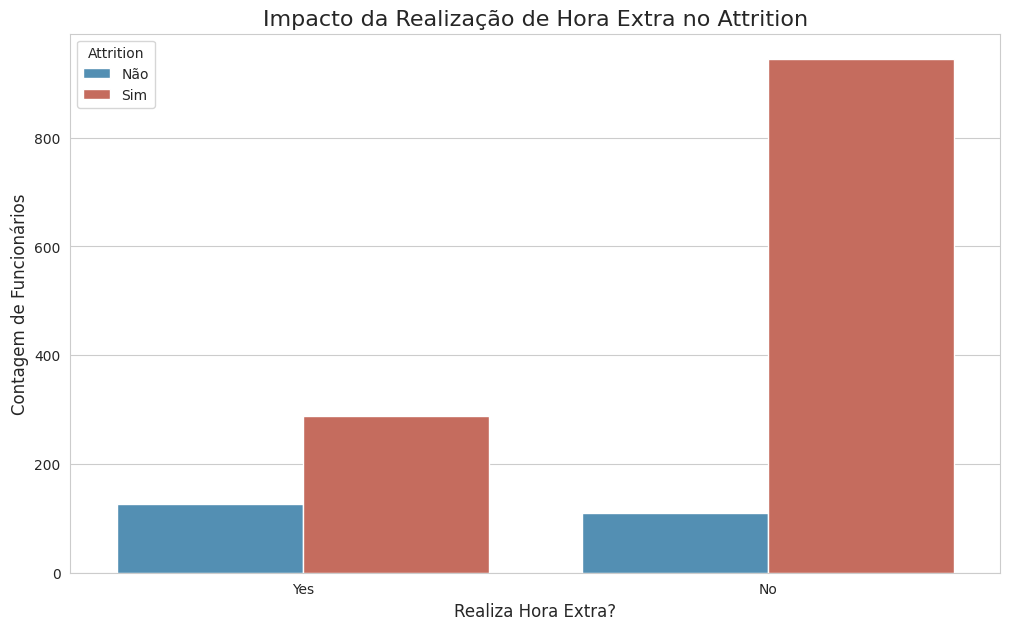

/tmp/ipython-input-42-1401708658.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attrition_por_cargo.values, y=attrition_por_cargo.index, palette='viridis', orient='h')


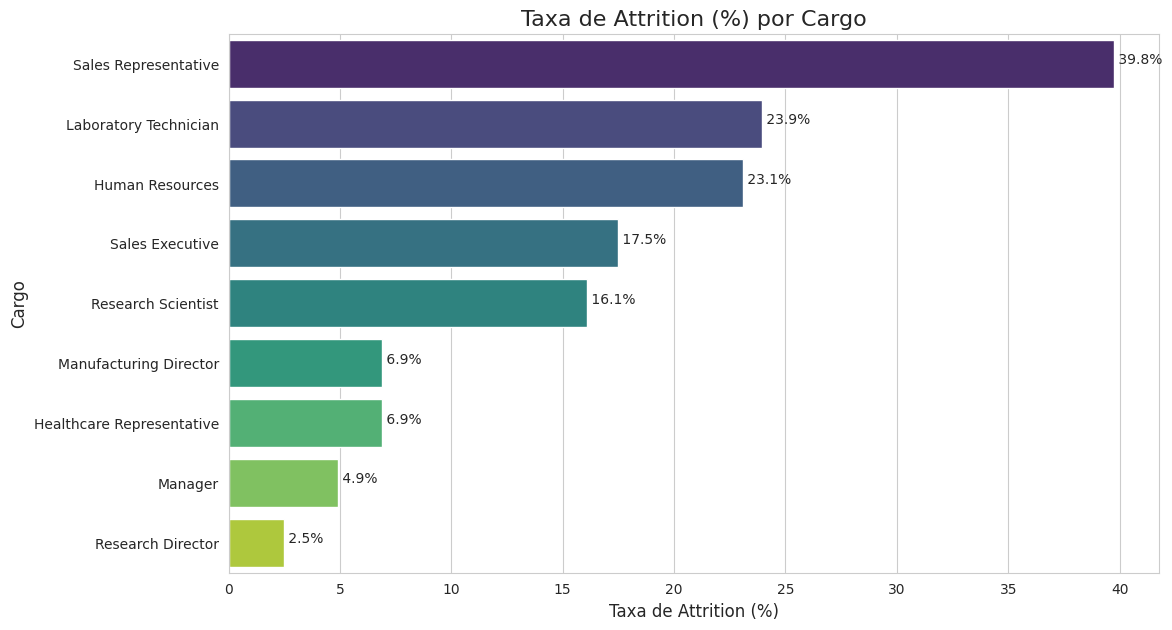

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configurações de Estilo para os Gráficos ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Define um bom tamanho para os gráficos

# --- Carregar o Dataset Original ---
# Certifique-se de que o arquivo .csv está disponível no ambiente do Colab
try:
    df_original = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
    print("Dataset original carregado com sucesso.")
except FileNotFoundError:
    print("Erro: Arquivo 'WA_Fn-UseC_-HR-Employee-Attrition.csv' não encontrado. Por favor, faça o upload.")
    df_original = None

if df_original is not None:
    # ==============================================================================
    # GRÁFICO 1: Contagem de Attrition por Realização de Hora Extra (OverTime)
    # ==============================================================================
    plt.figure() # Cria uma nova figura para o primeiro gráfico
    sns.countplot(x='OverTime', hue='Attrition', data=df_original, palette=['#4393C3', '#D6604D'])
    plt.title('Impacto da Realização de Hora Extra no Attrition', fontsize=16)
    plt.xlabel('Realiza Hora Extra?', fontsize=12)
    plt.ylabel('Contagem de Funcionários', fontsize=12)
    plt.legend(title='Attrition', labels=['Não', 'Sim'])
    plt.show()

    # ==============================================================================
    # GRÁFICO 2: Taxa de Attrition (%) por Cargo (JobRole)
    # ==============================================================================
    # Criar uma coluna numérica para Attrition para calcular a média
    df_original['Attrition_num'] = df_original['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Calcular a taxa de attrition por cargo
    attrition_por_cargo = df_original.groupby('JobRole')['Attrition_num'].mean().sort_values(ascending=False) * 100

    plt.figure() # Cria uma nova figura para o segundo gráfico
    sns.barplot(x=attrition_por_cargo.values, y=attrition_por_cargo.index, palette='viridis', orient='h')
    plt.title('Taxa de Attrition (%) por Cargo', fontsize=16)
    plt.xlabel('Taxa de Attrition (%)', fontsize=12)
    plt.ylabel('Cargo', fontsize=12)
    # Adicionar os valores nas barras para clareza
    for index, value in enumerate(attrition_por_cargo):
        plt.text(value, index, f' {value:.1f}%')
    plt.show()

Gerando o Gráfico SHAP Summary Plot...


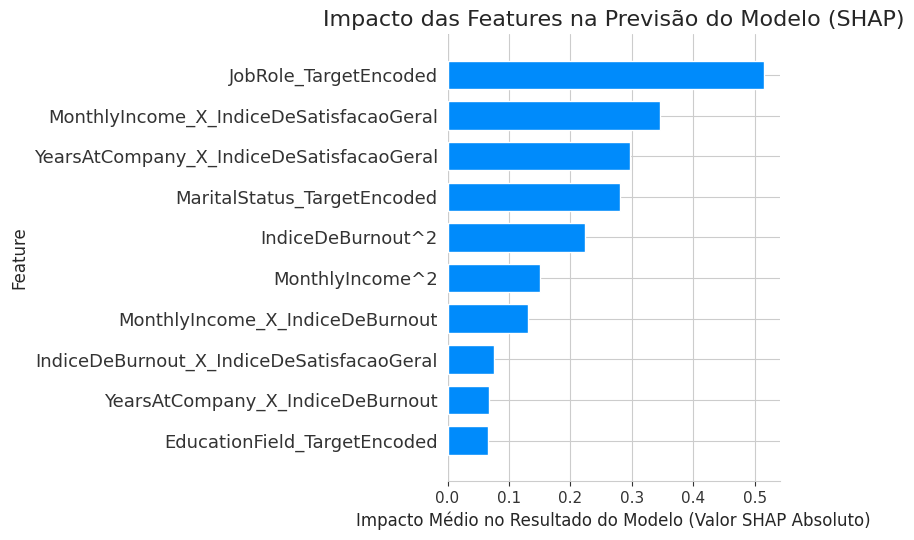

In [43]:
import shap
import matplotlib.pyplot as plt

# Supondo que 'best_xgb' é o seu modelo campeão já treinado (após o GridSearchCV)
# e 'X_test' é o seu conjunto de teste.

# 1. Criar o 'explainer' para o modelo final
# O explainer é o objeto que sabe como interpretar o seu modelo específico.
explainer = shap.Explainer(best_xgb)

# 2. Calcular os valores SHAP para o conjunto de teste
# Isso calcula o impacto de cada feature para cada previsão no conjunto de teste.
shap_values = explainer(X_test)

# 3. Gerar o gráfico de barras SHAP (Summary Plot)
print("Gerando o Gráfico SHAP Summary Plot...")

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('Impacto das Features na Previsão do Modelo (SHAP)', fontsize=16)
plt.xlabel('Impacto Médio no Resultado do Modelo (Valor SHAP Absoluto)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout() # Ajusta o layout para evitar cortes
plt.show()